In [28]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from scipy.ndimage import measurements
from collections import defaultdict
import numba as nb

In [29]:
# Another one with no fixed end point.

url='https://www.janestreet.com/puzzles/fences/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:20]))

A 17-by-17 field is divided into unit squares. Some of the squares contain “posts” at their center. Each post is represented below by a number. Construct one or more fences emanating from each post, such that the total length of fence connected to a post equals the number given. Fences have integer length and can only be constructed horizontally or vertically. Fences from different posts may not touch, nor may a fence from one post touch a different post. The goal of this puzzle is to build your fences in such a manner that it is possible to draw a closed loop through some of the remaining empty squares. The loop must enclose at least one post, and must be symmetric in some way (either via rotation or reflection). As in the example, the loop must be rectilinear, passing through the centers of adjacent empty squares. The answer to this puzzle is the product of the fence-lengths of the fences inside the loop . (Note that in the Example, the answer is 2 , not 4.)


### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2019/01/20190101_fences.png" width="350">

(0.0, 17.0, 17.0, 0.0)

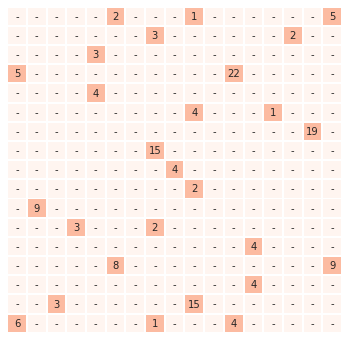

In [30]:
# Setup the constraints
fixed = np.array([[0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 5],
                  [0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0],
                  [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 0],
 [0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
 [0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0],
 [0, 0, 3, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 0, 0, 0],
 [6, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0]],dtype=int)

fig,ax = plt.subplots(1,1,figsize=(6,6))
x = np.array(fixed.astype('int').astype('str'))
x[x=="0"] ="-"
ax =sns.heatmap(fixed>0,annot=x,cbar=False,cmap="Reds",center =2,fmt="",linewidths=1)
ax.axis("off")



In [127]:
class Matrix():
    def __init__(self,fixed):
        self.fixed = fixed
        
    #########################################
    # define possible moves 

    def clearance(self,grid,row,col):
        num = grid[row,col]
        
        top = grid[:row,col][::-1]
        bot = grid[row+1:,col]
        lhs = grid[row,:col][::-1]
        rhs = grid[row,col+1:]
        bounds = [top,bot,lhs,rhs]
        
        allowed = [-num,0]
        clearance = []
        
        for i in range(4):

            for n in range(len(bounds[i])):
                if bounds[i][n] not in allowed:
                    n -=1
                    break                        
            if len(bounds[i])==0:
                n=-1
            clearance.append(n+1)
        
        return clearance
    
    def forced_by_clearance(self,grid):
        for row,col in itertools.product(range(17),range(17)):
            num = grid[row,col]
            if num >0:
                bounds = self.clearance(grid,row,col)
                forced = [max(0,num-np.sum(bounds)+bounds[i]) for i in range(4)]
                [top,bot,lhs,rhs] =forced
                grid[row-top:row,col] = -num
                grid[row+1:row+1+bot,col] = -num
                grid[row,col-lhs:col] = -num
                grid[row,col+1:col+1+rhs] = -num
        return grid
   
    ##############################################
    # Turn the grid moves into a nice format

                         
    ###############################################
    # Main solver.  
    def solve(self):
        start = time.time()
        grid=dcopy(fixed)
        changed = True
        while changed:
            changed = False
            copy_grid = dcopy(grid)
            grid = self.forced_by_clearance(grid)
            if np.any(copy_grid !=grid):
                changed=True
                
        fig,ax = plt.subplots(1,1,figsize=(6,6))
        x = np.array(grid.astype('int').astype('str'))
        x[x=="0"] ="-"
        ax =sns.heatmap(fixed>0,annot=x,cbar=False,cmap="Reds",center =2,fmt="",linewidths=1)
        ax.axis("off")        
            
        print("***Solved in {:.15f} seconds***\n".format(time.time() - start))        
        
        

0 5 [0, 12, 5, 3]
0 9 [0, 4, 3, 6]
0 16 [0, 12, 6, 0]
1 7 [1, 5, 7, 6]
1 14 [1, 15, 6, 2]
2 4 [2, 1, 4, 12]
3 0 [3, 12, 0, 10]
3 11 [3, 12, 10, 5]
4 4 [1, 12, 4, 6]
5 9 [1, 3, 9, 1]
5 13 [5, 11, 1, 3]
6 15 [6, 10, 3, 1]
7 7 [5, 3, 7, 3]
8 8 [8, 8, 8, 6]
9 9 [3, 5, 9, 5]
10 1 [10, 6, 1, 13]
11 3 [3, 5, 3, 3]
11 7 [3, 4, 3, 7]
12 12 [12, 1, 12, 2]
13 5 [5, 3, 5, 9]
13 16 [12, 3, 0, 0]
14 12 [1, 2, 12, 2]
15 2 [15, 1, 2, 6]
15 9 [5, 1, 6, 5]
16 0 [12, 0, 0, 6]
16 7 [0, 0, 6, 3]
16 11 [0, 0, 3, 5]
0 5 [0, 6, 5, 3]
0 9 [0, 2, 3, 6]
0 16 [0, 6, 6, 0]
1 7 [1, 3, 7, 6]
1 14 [1, 4, 6, 0]
2 4 [2, 1, 4, 10]
3 0 [3, 12, 0, 8]
3 11 [3, 11, 10, 3]
4 4 [1, 2, 4, 6]
5 9 [1, 3, 1, 1]
5 13 [5, 0, 1, 1]
6 15 [6, 10, 3, 1]
7 7 [3, 3, 7, 3]
8 8 [0, 6, 0, 2]
9 9 [1, 2, 0, 1]
10 1 [2, 6, 1, 6]
11 3 [3, 5, 3, 3]
11 7 [1, 3, 3, 7]
12 12 [12, 1, 2, 2]
13 5 [5, 1, 5, 3]
13 16 [12, 3, 0, 0]
14 12 [1, 0, 2, 2]
15 2 [7, 1, 2, 2]
15 9 [5, 1, 6, 5]
16 0 [12, 0, 0, 6]
16 7 [0, 0, 6, 3]
16 11 [0, 0, 3, 5]
0 5 [0, 6, 5,

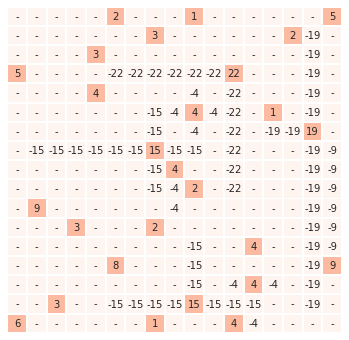

In [128]:
test = Matrix(fixed)
test.solve()

In [44]:
url='https://www.janestreet.com/puzzles/solutions/january-2019-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:10]))

The unique configuration that works is shown to the left. The product of the lengths of the fences inside the loop is 10,077,696 . Nicely done, solvers!


<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2019/02/20190130_fences_solved.png" width="350">

(0.0, 17.0, 17.0, 0.0)

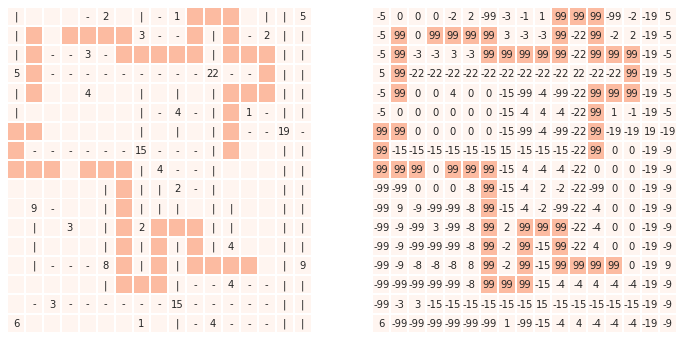

In [84]:
solved = np.array([
    [ -5,   0,   0,   0,  -2,   2, -99,  -3,  -1,   1,  99,  99,  99,-99,  -2, -19,   5],
    [ -5,  99,   0,  99,  99,  99,  99,   3,  -3,  -3,  99, -22,  99, -2,   2, -19,  -5],
    [ -5,  99,  -3,  -3,   3,  -3,  99,  99,  99,  99,  99, -22,  99, 99,  99, -19,  -5],
    [  5,  99, -22, -22, -22, -22, -22, -22, -22, -22, -22,  22, -22,-22,  99, -19,  -5],
    [ -5,  99,   0,   0,   4,   0,   0, -15, -99,  -4, -99, -22,  99,  99,  99, -19,  -5],
    [ -5,   0,   0,   0,   0,   0,   0, -15,  -4,   4,  -4, -22,  99,   1,  -1, -19,  -5],
    [ 99,  99,   0,   0,   0,   0,   0, -15, -99,  -4, -99, -22,  99, -19, -19,  19, -19],
    [ 99, -15, -15, -15, -15, -15, -15,  15, -15, -15, -15, -22,  99,   0,   0, -19,  -9],
    [ 99,  99,  99,   0,  99,  99,  99, -15,   4,  -4,  -4, -22,   0,   0,   0, -19,  -9],
    [-99, -99,   0,   0,   0,  -8,  99, -15,  -4,   2,  -2, -22, -99,   0,   0, -19,  -9],
    [-99,   9,  -9, -99, -99,  -8,  99, -15,  -4,  -2, -99, -22,  -4,   0,   0, -19,  -9],
    [-99,  -9, -99,   3, -99,  -8,  99,   2,  99,  99,  99, -22,  -4,   0,   0, -19,  -9],
    [-99,  -9, -99, -99, -99,  -8,  99,  -2,  99, -15,  99, -22,   4,   0,   0, -19,  -9],
    [-99,  -9,  -8,  -8,  -8,   8,  99,  -2,  99, -15,  99,  99,  99,  99,   0, -19,   9],
    [-99, -99, -99, -99, -99,  -8,  99,  99,  99, -15,  -4,  -4,   4,  -4,  -4, -19,  -9],
    [-99,  -3,   3, -15, -15, -15, -15, -15, -15,  15, -15, -15, -15, -15, -15, -19,  -9],
    [  6, -99, -99, -99, -99, -99, -99,   1, -99, -15,  -4,   4,  -4,  -4,  -4, -19,  -9]])

annot=np.zeros((17,17)).astype('int').astype('str')

for i,j in itertools.product(range(17),range(17)):
    test = solved[i,j]
    if  abs(test) == 99 or test==0 :
        annot[i,j]=""
    elif test > 0:
        annot[i,j] =str(test)
    elif test < 0:
        if i-1 > -1:
            if abs(test) ==  abs(solved[i-1,j]):
                annot[i,j] ="|"
        if i+1 < 17:
            if abs(test) ==  abs(solved[i+1,j]):
                annot[i,j] ="|"
        if j-1 > -1:
            if abs(test) ==  abs(solved[i,j-1]):
                annot[i,j] ="-"
        if j+1 < 17:
            if abs(test) ==  abs(solved[i,j+1]):
                annot[i,j] ="-"

  
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0] =sns.heatmap(solved==99,annot=annot,cbar=False,cmap="Reds",center =2,fmt="",linewidths=1,ax=ax[0])
ax[0].axis("off")
ax[1] =sns.heatmap(solved==99,annot=solved,cbar=False,cmap="Reds",center =2,fmt="",linewidths=1,ax=ax[1])
ax[1].axis("off")